In [2]:
# %pip install OSMPythonTools

In [1]:
# %pip install shapely

In [16]:
%pip install osmnx

Note: you may need to restart the kernel to use updated packages.


In [17]:
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt

import requests
from shapely.geometry import shape
from shapely.geometry import Polygon, LineString, MultiLineString
from shapely.ops import polygonize, unary_union

import osmnx as ox

# from OSMPythonTools.api import Api
# from OSMPythonTools.overpass import Overpass
# from OSMPythonTools.nominatim import Nominatim

# import random
# from shapely.geometry import Point, LineString
# from shapely.ops import unary_union
# from shapely import offset_curve
# from dotenv import load_dotenv
# import requests

%matplotlib inline
pd.set_option('display.max_columns', None)  # Show all columns

In [2]:
# def fetch_osm_features(area_name, tags, element_types=('way', 'relation')):
#     """
#     Query Overpass API for given tag-value pairs within a named area.
#     Args:
#         tags (dict): Dictionary of tag-value pairs to query.
#         area_name (str): OSM area name to search within.
#         element_types (tuple): Tuple of element types to fetch (e.g., ('way', 'relation')).  
#     Returns:
#         gpd.GeoDataFrame: GeoDataFrame of geometries with attributes.
#     """
    
#     overpass_url = "https://overpass-api.de/api/interpreter"

#     # Build Overpass tag filter for specified element types
#     tag_filters = "\n".join(
#         f'  {etype}["{k}"="{v}"](area.searchArea);'
#         for etype in element_types
#         for k, v in tags.items()
#     )

#     # Build full query
#     overpass_query = f"""
#     [out:json][timeout:300];
#     area["name"="{area_name}"]->.searchArea;
#     (
#     {tag_filters}
#     );
#     out body;
#     >;
#     out skel qt;
#     """

#     # Query Overpass API
#     response = requests.get(overpass_url, params={'data': overpass_query})
#     data = response.json()

#     # Split OSM elements by type
#     nodes = {}
#     ways = []
#     relations = []

#     for el in data['elements']:
#         if el['type'] == 'node':
#             nodes[el['id']] = (el['lon'], el['lat'])
#         elif el['type'] == 'way':
#             ways.append(el)
#         elif el['type'] == 'relation':
#             relations.append(el)

#      # Build geometries from ways
#     features = []
#     if 'way' in element_types:
#         for way in ways:
#             try:
#                 coords = [nodes[nid] for nid in way['nodes'] if nid in nodes]
                
#                 if len(coords) > 0:  # Make sure we have valid coordinates
#                     if coords[0] == coords[-1]:  # Closed polygon
#                         geometry = Polygon(coords)
#                     else:  # LineString if not closed
#                         geometry = LineString(coords)
#                     features.append({
#                         'id': way['id'],
#                         'tags': way.get('tags', {}),
#                         'geometry': geometry
#                     })
#             except KeyError:
#                 continue  # Incomplete geometry, skip

#     # Handle relations if needed
#     if 'relation' in element_types:
#         for relation in relations:
#             try:
#                 coords = []
#                 for member in relation['members']:
#                     if member['type'] == 'way' and member['ref'] in ways:
#                         # Fetch way and add its coordinates
#                         way = next(w for w in ways if w['id'] == member['ref'])
#                         way_coords = [nodes[nid] for nid in way['nodes'] if nid in nodes]
                        
#                         if way_coords:  # Only add coordinates if they are valid
#                             coords.extend(way_coords)

#                 if len(coords) > 0:  # Ensure coords is not empty
#                     if coords[0] == coords[-1]:  # Closed polygon
#                         geometry = Polygon(coords)
#                     else:  # LineString if not closed
#                         geometry = LineString(coords)

#                     features.append({
#                         'id': relation['id'],
#                         'tags': relation.get('tags', {}),
#                         'geometry': geometry
#                     })
#             except KeyError:
#                 continue  # Skip incomplete relations


#     # Build GeoDataFrame
#     gdf = gpd.GeoDataFrame(features, geometry='geometry', crs='EPSG:4326')
#     gdf = gdf.to_crs(epsg=27700)

#     # # Convert Linestrings to Polygons
#     # def close_and_convert(ls):
#     #     if ls.coords[0] != ls.coords[-1]:
#     #         coords = list(ls.coords)
#     #         coords.append(coords[0])  # Force close
#     #         return Polygon(coords)
#     #     return Polygon(ls.coords)

#     # # Apply only to LineStrings
#     # gdf['geometry'] = gdf['geometry'].apply(
#     #     lambda geom: close_and_convert(geom) if isinstance(geom, LineString) else geom
#     # )

#     # Flatten tags into columns
#     if not gdf.empty:
#         tags_df = pd.json_normalize(gdf['tags'])
#         gdf = pd.concat([gdf.drop(columns='tags'), tags_df], axis=1)

#     return gdf

In [3]:
# # This section is to fetch the features from the expected tags
# tags_1 = [
#     # {"leisure": "park", "access": "public"}
#     # ,{"leisure": "nature_reserve", "access": "public"}
#     # ,{"leisure": "garden", "access": "public"},
#     {"boundary": "protected_area"}
#     # ,{"natural": "wood", "access": "public"}
# ]
# names = ["parks", "nature_reserves", "gardens", "protected_areas", "woods"]

# features_1 = {}
# for idx, group in enumerate(tags_1):
#     group_name = f"gdf_{names[idx]}"
#     print(f"Fetching group: {group_name}...")
#     gdf_group = fetch_osm_features("United Kingdom", group, element_types=("way", "relation"))
#     print(f"Fetched. Total features: {len(gdf_group)}")
#     features_1[group_name] = gdf_group

In [105]:
# test = features_1["gdf_parks"]

In [4]:
# test.info()

In [5]:
# test.geometry

In [7]:
# len(test.name.drop_duplicates())

In [8]:
# test['geometry'].geom_type.value_counts()

In [9]:
# fig, ax = plt.subplots(figsize=(20, 20))

# test.plot(ax=ax, label=name, cmap='tab20', alpha=0.6)

# plt.title("Combined Features by Group")
# plt.legend()
# plt.axis('off')
# plt.show()

In [46]:
# for i in range(0,20):
#     test.iloc[[i]].plot()

In [10]:
# test.head()

In [11]:
# # Group by name and combine geometries into MultiPolygons where needed
# test_grouped = test.dissolve(by='name', as_index=False)

# # This will give you unique names with combined geometries (MultiPolygons or merged Polygons)
# print(test_grouped.head())

In [12]:
# # Function to combine multiple LineStrings into a single LineString (closed if possible)
# def combine_linestrings(lines):
#     # Check if the input is empty
#     if len(lines) == 0:
#         return None
    
#     # Combine all LineStrings in the group into a single geometry (unary_union handles merging)
#     combined = lines.unary_union
    
#     # If the result is a MultiLineString, we will merge them into a single LineString
#     if isinstance(combined, LineString):
#         # Check if it's already a closed loop
#         if combined.coords[0] != combined.coords[-1]:
#             # Close the loop
#             coords = list(combined.coords)
#             coords.append(coords[0])  # Force close the loop
#             combined = LineString(coords)  # Create a new closed LineString
#     else:
#         # Handle MultiLineString (merge all line segments)
#         combined = combined.simplify(0.0001)  # Simplify geometry slightly (optional)
#         # You can decide whether to return a MultiLineString or merge it into a single LineString
#         if isinstance(combined, MultiLineString):
#             combined = combined.convex_hull  # For simplicity, we can use convex hull as a fallback
    
#     return combined

# # Assuming 'test' is your GeoDataFrame with columns 'name' and 'geometry'

# # Step 1: Group by 'name' and apply the combine_linestrings function
# combined_geometries = (
#     test[test.geometry.type == 'LineString']  # Select only LineString geometries
#     .groupby('name')['geometry']
#     .apply(combine_linestrings)
#     .reset_index(name='geometry')  # Reset index so we get a proper DataFrame again
# )

# # Step 2: Merge combined LineStrings with original Polygons (no change to polygons)
# polygons = test[test.geometry.type == 'Polygon']

# # Combine the two DataFrames (polygons and combined LineStrings)
# final_gdf = pd.concat([polygons, combined_geometries], ignore_index=True)

# # Step 3: Create a new GeoDataFrame
# final_gdf = gpd.GeoDataFrame(final_gdf, geometry='geometry', crs=test.crs)

# # Visualize the result
# final_gdf.plot()

In [13]:
# linestrings = test[test.geometry.type == 'LineString']

In [14]:
# linestrings.plot()

In [131]:
protected_areas = ox.features_from_place("United Kingdom", tags = {"boundary": "protected_area"})

/opt/conda/lib/python3.11/site-packages/osmnx/_overpass.py:267: UserWarning: This area is 330 times your configured Overpass max query area size. It will automatically be divided up into multiple sub-queries accordingly. This may take a long time.
  multi_poly_proj = utils_geo._consolidate_subdivide_geometry(poly_proj)


<Axes: >

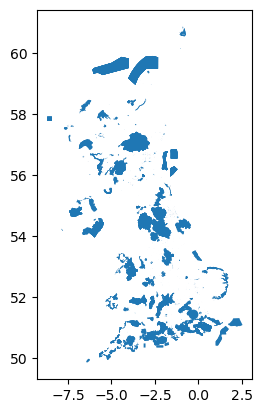

In [132]:
parks = ox.features_from_place("United Kingdom", tags = {"leisure": "park", "access": "public"})

/tmp/ipykernel_70819/2041686567.py:6: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


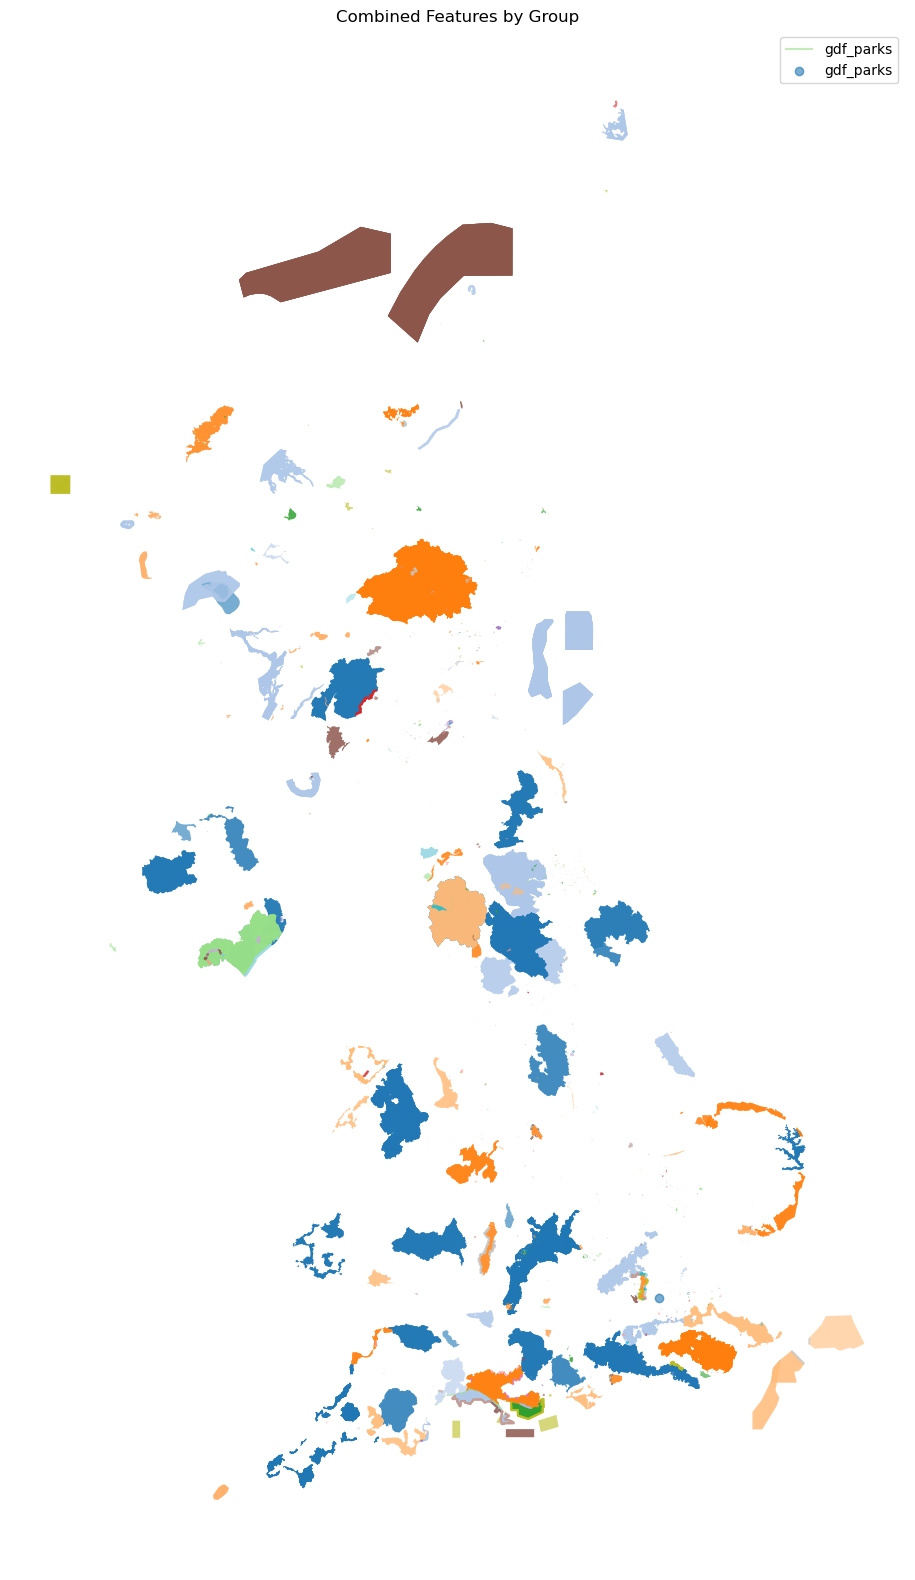

In [138]:
fig, ax = plt.subplots(figsize=(20, 20))

buildings.plot(ax=ax, label=name, cmap='tab20', alpha=0.6)

plt.title("Combined Features by Group")
plt.legend()
plt.axis('off')
plt.show()

In [140]:
exmoor = buildings[buildings["name"].str.contains("Exmoor National Park", case=False, na=False)]

<Axes: >

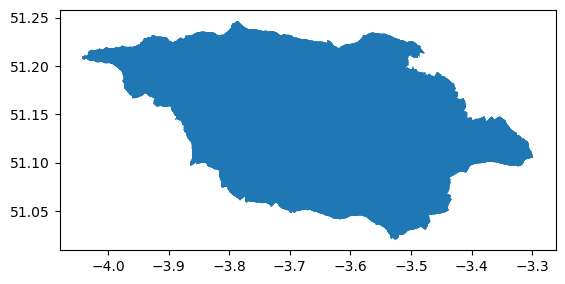

In [141]:
exmoor.plot()

In [143]:
exmoor

geometry  \
element  id                                                         
relation 86909  POLYGON ((-4.04233 51.20804, -4.04248 51.20817...   
         86909  POLYGON ((-4.04233 51.20804, -4.04248 51.20817...   
         86909  POLYGON ((-4.04233 51.20804, -4.04248 51.20817...   
         86909  POLYGON ((-4.04233 51.20804, -4.04248 51.20817...   

                      boundary protect_class related_law  \
element  id                                                
relation 86909  protected_area             5         NaN   
         86909  protected_area             5         NaN   
         86909  protected_area             5         NaN   
         86909  protected_area             5         NaN   

                                name protection_title wikidata  wikipedia  \
element  id                                                                 
relation 86909  Exmoor National Park    national_park  Q593627  en:Exmoor   
         86909  Exmoor National Park    national_park  Q593627  en:Exmoor   
         86909  Exmoor National Park    national_park  Q593627  en:Exmoor   
         86909  Exmoor National Park    national_park  Q593627  en:Exmoor   

               operator place alt_name loc_name protect_id source leisure  \
element  id                                                                 
relation 86909      NaN   NaN      NaN      NaN        NaN    NaN     NaN   
         86909      NaN   NaN      NaN      NaN        NaN    NaN     NaN   
         86909      NaN   NaN      NaN      NaN        NaN    NaN     NaN   
         86909      NaN   NaN      NaN      NaN        NaN    NaN     NaN   

               name:ga  ref start_date  \
element  id                              
relation 86909     NaN  NaN        NaN   
         86909     NaN  NaN        NaN   
         86909     NaN  NaN        NaN   
         86909     NaN  NaN        NaN   

                                                website boundary_type name:en  \
element  id                                                                     
relation 86909  https://www.exmoor-nationalpark.gov.uk/           NaN     NaN   
         86909  https://www.exmoor-nationalpark.gov.uk/           NaN     NaN   
         86909  https://www.exmoor-nationalpark.gov.uk/           NaN     NaN   
         86909  https://www.exmoor-nationalpark.gov.uk/           NaN     NaN   

               waterway                                               note  \
element  id                                                                  
relation 86909      NaN  Contains public sector information licensed un...   
         86909      NaN  Contains public sector information licensed un...   
         86909      NaN  Contains public sector information licensed un...   
         86909      NaN  Contains public sector information licensed un...   

               layer area description    designation geological operator:type  \
element  id                                                                     
relation 86909   NaN  NaN         NaN  national_park        NaN           NaN   
         86909   NaN  NaN         NaN  national_park        NaN           NaN   
         86909   NaN  NaN         NaN  national_park        NaN           NaN   
         86909   NaN  NaN         NaN  national_park        NaN           NaN   

               addr:street archaeological_site historic opening_hours  \
element  id                                                             
relation 86909         NaN                 NaN      NaN           NaN   
         86909         NaN                 NaN      NaN           NaN   
         86909         NaN                 NaN      NaN           NaN   
         86909         NaN                 NaN      NaN           NaN   

               operator:wikidata natural name:gd not:operator:wikidata  \
element  id                                                              
relation 86909               NaN     NaN     NaN                   NaN  

/tmp/ipykernel_70819/1924459697.py:6: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


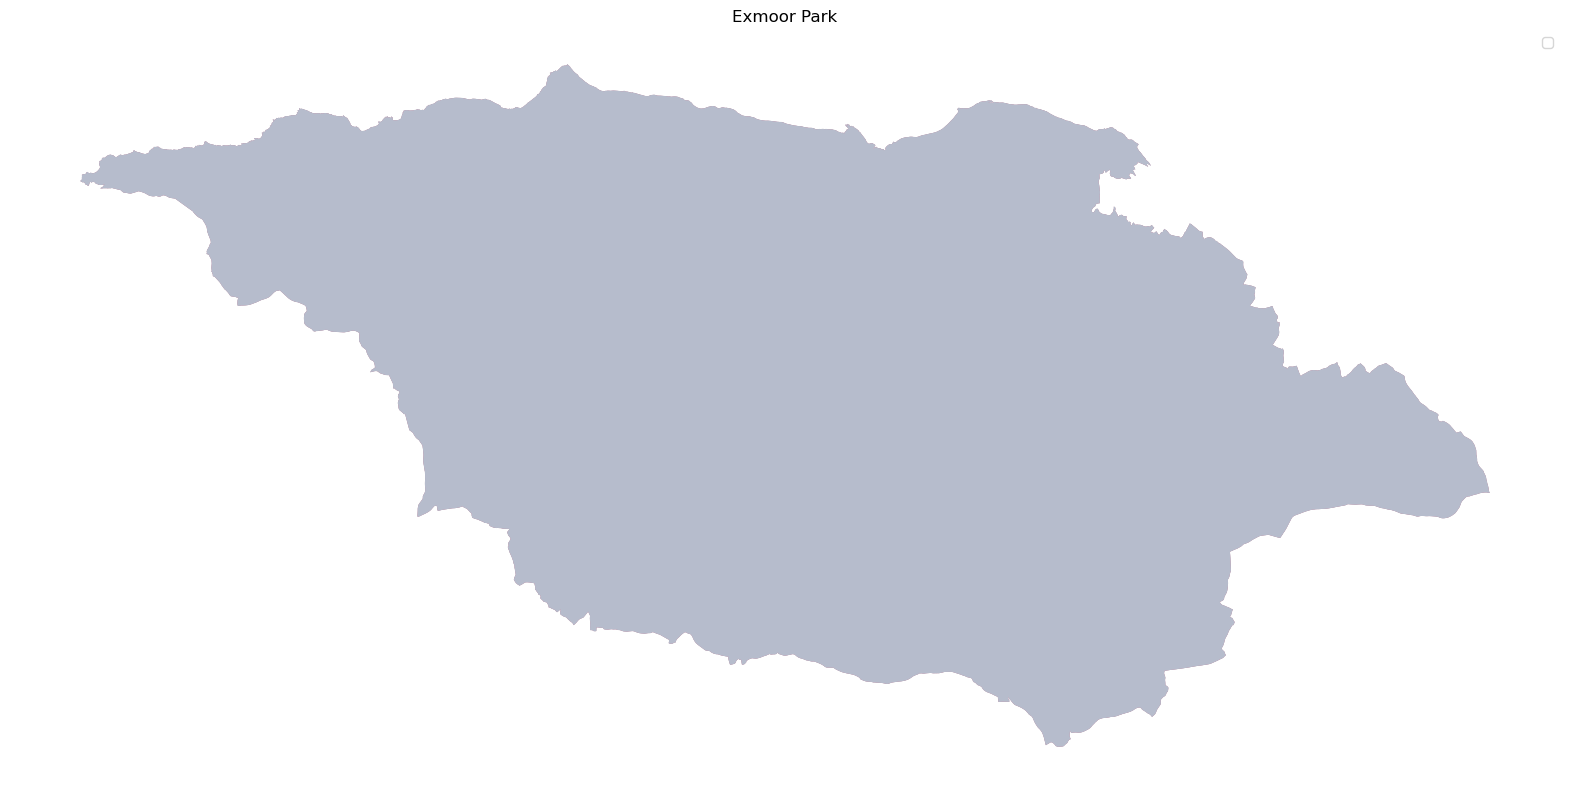

In [142]:
fig, ax = plt.subplots(figsize=(20, 20))

exmoor.plot(ax=ax, label=name, cmap='tab20', alpha=0.6)

plt.title("Exmoor Park")
plt.legend()
plt.axis('off')
plt.show()

In [144]:
# Group by name and combine geometries into MultiPolygons where needed
buildings_grouped = buildings.dissolve(by='name', as_index=False)

# This will give you unique names with combined geometries (MultiPolygons or merged Polygons)
# print(buildings_grouped.head())

In [149]:
len(buildings_grouped.name.drop_duplicates()) - len(buildings_grouped.name.unique())

0

In [155]:
buildings_grouped_nomarine = buildings_grouped.dropna(subset=["protection_title"])
buildings_grouped_nomarine = buildings_grouped_nomarine[~buildings_grouped_nomarine["protection_title"].str.contains("marine", case=False)]

In [154]:
# buildings_grouped_nomarine = buildings_grouped.drop(buildings_grouped["protection_title"].str.contains("marine", case=False, na=False))

In [152]:
buildings_grouped.protection_title.value_counts()

protection_title
Site of Special Scientific Interest                       70
world_heritage_convention                                 20
Marine Protected Area                                     19
national_park                                             14
area_of_outstanding_natural_beauty                        11
Local Nature Reserve                                      10
Conservation Area                                         10
Area of Special Scientific Interest                        8
conservation_area                                          7
Conservation Areas                                         6
National Nature Reserve                                    5
Marine Conservation Zone                                   5
Nature Reserve                                             4
sssi                                                       4
SSSI                                                       4
Conservation_Area                                          4
Regiona

/tmp/ipykernel_70819/2035614934.py:19: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if row.geometry.type == 'Polygon':
/tmp/ipykernel_70819/2035614934.py:26: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


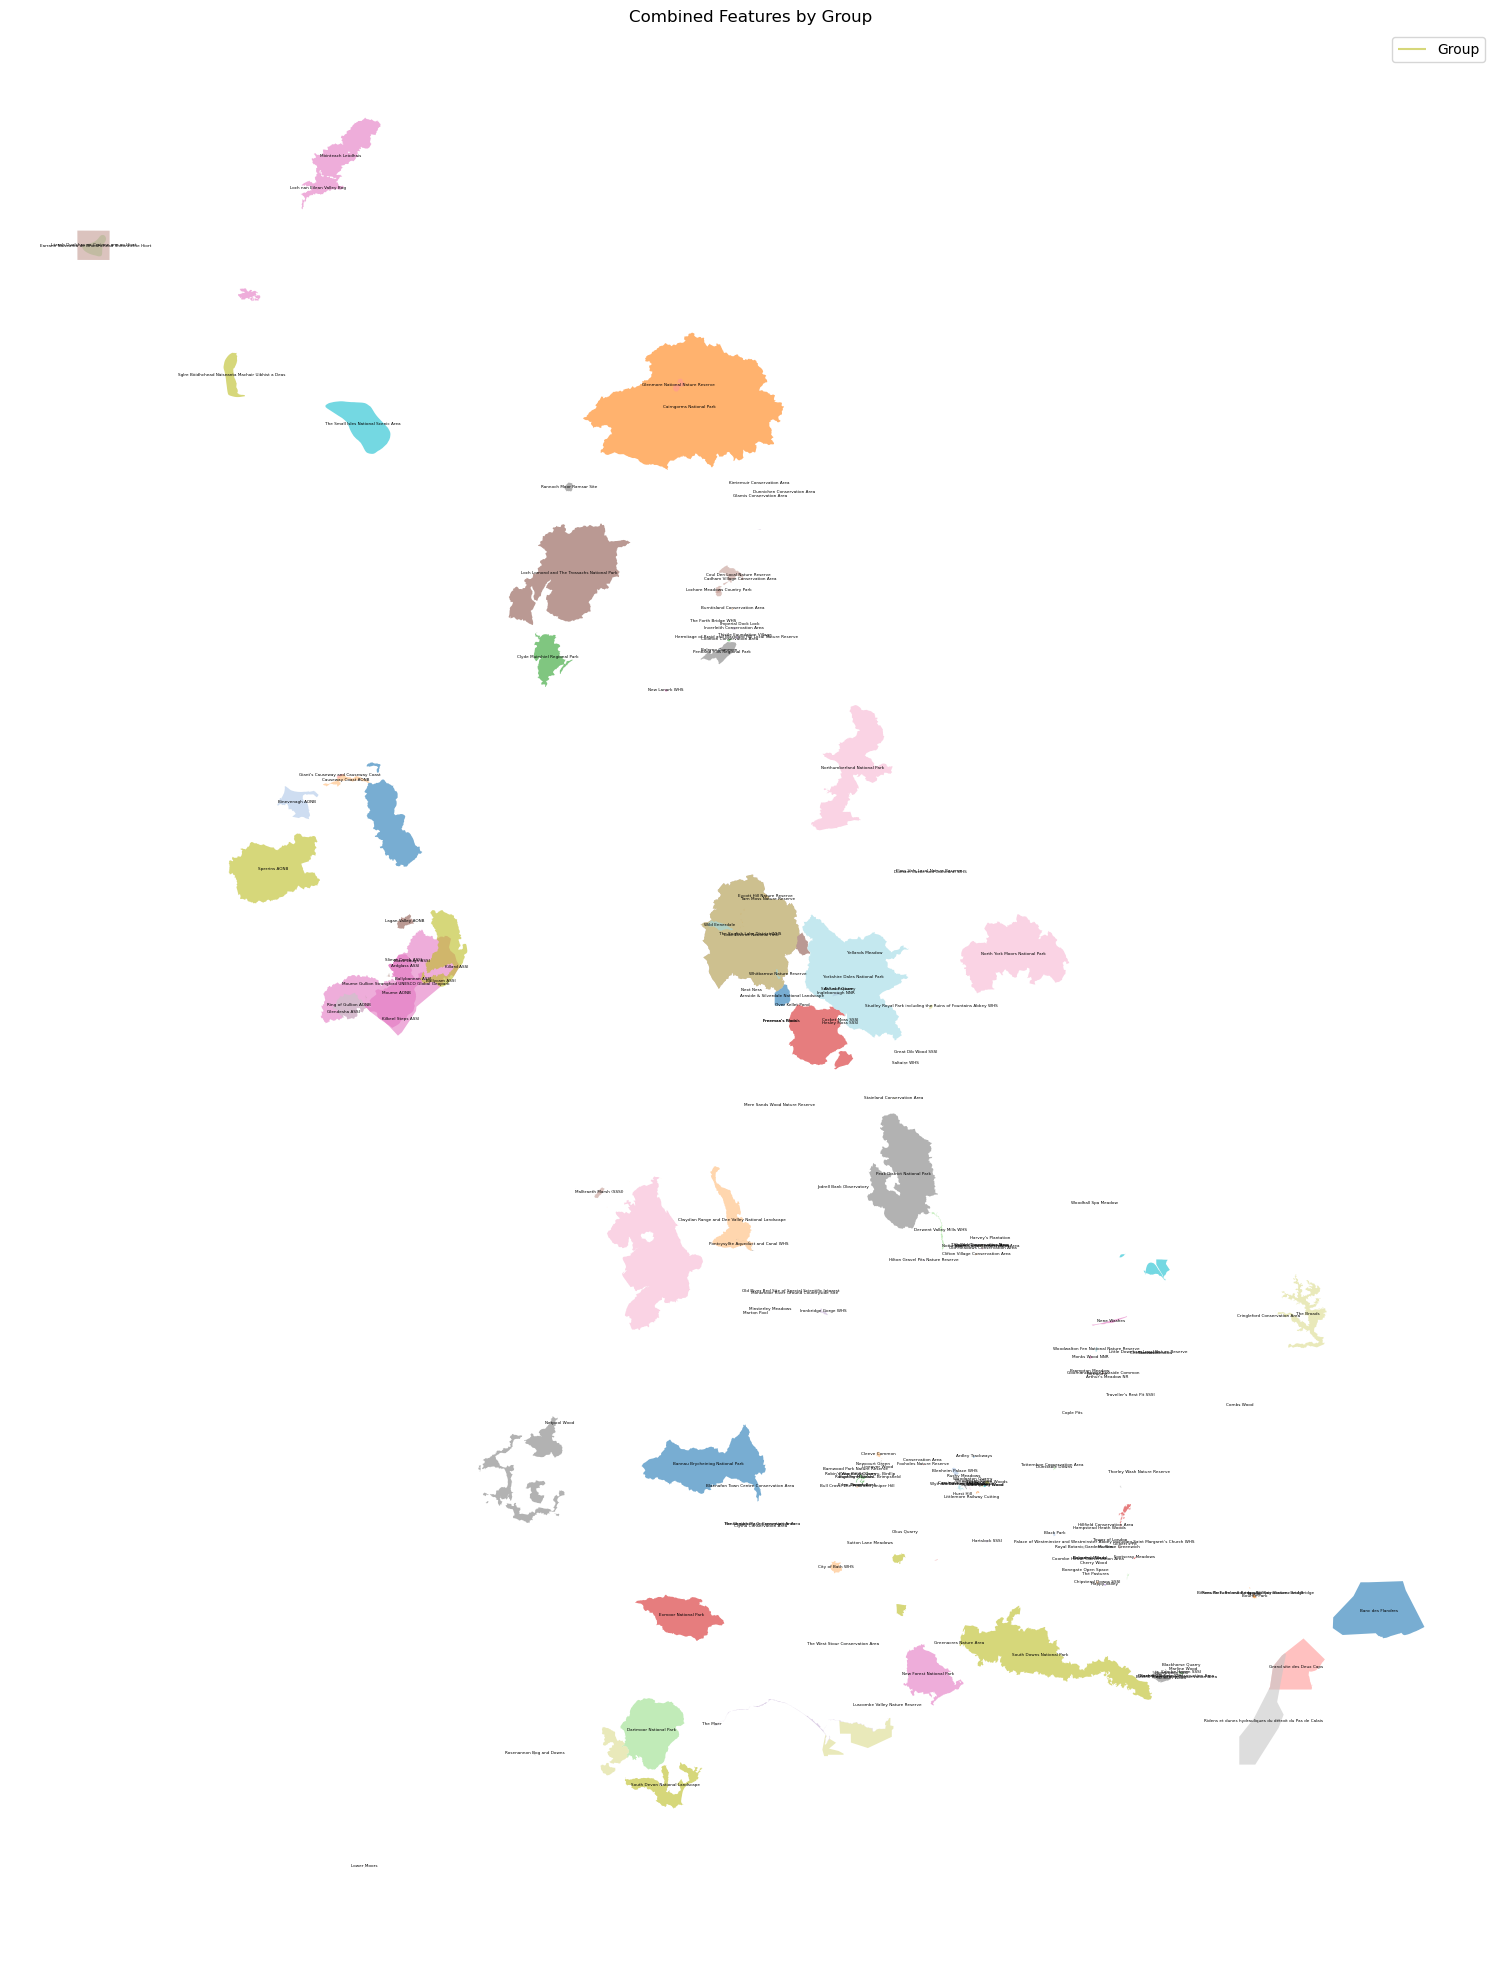

In [156]:
# fig, ax = plt.subplots(figsize=(20, 20))

# buildings_grouped.plot(ax=ax, label=name, cmap='tab20', alpha=0.6)

# plt.title("Combined Features by Group")
# plt.legend()
# plt.axis('off')
# plt.show()

# Create a plot
fig, ax = plt.subplots(figsize=(25, 25))

# Plot the geometries
buildings_grouped_nomarine.plot(ax=ax, label="Group", cmap='tab20', alpha=0.6)

# Add labels over the shapes
for idx, row in buildings_grouped_nomarine.iterrows():
    # Get the centroid of the shape (Polygon)
    if row.geometry.type == 'Polygon':
        centroid = row.geometry.centroid
        # Add a label with the value from the "name" column
        ax.text(centroid.x, centroid.y, row['name'], fontsize=3, ha='center', color='black')

# Set the title and other plot properties
plt.title("Combined Features by Group")
plt.legend()
plt.axis('off')

# Show the plot
plt.show()


In [137]:
buildings.head(50)

geometry  \
element  id                                                              
node     5354765334                          POINT (-0.29943 51.44903)   
relation 86909       POLYGON ((-4.04233 51.20804, -4.04248 51.20817...   
         86909       POLYGON ((-4.04233 51.20804, -4.04248 51.20817...   
         86909       POLYGON ((-4.04233 51.20804, -4.04248 51.20817...   
         86909       POLYGON ((-4.04233 51.20804, -4.04248 51.20817...   
         165598      MULTIPOLYGON (((-5.27133 51.7023, -5.27135 51....   
         165598      MULTIPOLYGON (((-5.27133 51.7023, -5.27135 51....   
         165598      MULTIPOLYGON (((-5.27133 51.7023, -5.27135 51....   
         165598      MULTIPOLYGON (((-5.27133 51.7023, -5.27135 51....   
         166570      POLYGON ((-2.34116 51.67317, -2.34097 51.67318...   
         166570      POLYGON ((-2.34116 51.67317, -2.34097 51.67318...   
         166570      POLYGON ((-2.34116 51.67317, -2.34097 51.67318...   
         166570      POLYGON ((-2.34116 51.67317, -2.34097 51.67318...   
         166570      POLYGON ((-2.34116 51.67317, -2.34097 51.67318...   
         166570      POLYGON ((-2.34116 51.67317, -2.34097 51.67318...   
         233879      POLYGON ((-2.42636 52.04565, -2.42683 52.04713...   
         284135      POLYGON ((-6.45797 57.07345, -6.41362 57.07132...   
         287245      MULTIPOLYGON (((-3.95783 52.75027, -3.95792 52...   
         287245      MULTIPOLYGON (((-3.95783 52.75027, -3.95792 52...   
         287245      MULTIPOLYGON (((-3.95783 52.75027, -3.95792 52...   
         287245      MULTIPOLYGON (((-3.95783 52.75027, -3.95792 52...   
         287245      MULTIPOLYGON (((-3.95783 52.75027, -3.95792 52...   
         287917      POLYGON ((-3.49566 54.51733, -3.49559 54.51757...   
         287917      POLYGON ((-3.49566 54.51733, -3.49559 54.51757...   
         287917      POLYGON ((-3.49566 54.51733, -3.49559 54.51757...   
         287917      POLYGON ((-3.49566 54.51733, -3.49559 54.51757...   
         307985      POLYGON ((-2.61657 54.29124, -2.61637 54.29143...   
         307985      POLYGON ((-2.61657 54.29124, -2.61637 54.29143...   
         307985      POLYGON ((-2.61657 54.29124, -2.61637 54.29143...   
         307985      POLYGON ((-2.61657 54.29124, -2.61637 54.29143...   
         307985      POLYGON ((-2.61657 54.29124, -2.61637 54.29143...   
         357283      POLYGON ((-3.97422 51.84197, -3.97419 51.84199...   
         357283      POLYGON ((-3.97422 51.84197, -3.97419 51.84199...   
         357283      POLYGON ((-3.97422 51.84197, -3.97419 51.84199...   
         357283      POLYGON ((-3.97422 51.84197, -3.97419 51.84199...   
         383665      POLYGON ((-1.20383 54.16577, -1.20316 54.16599...   
         383665      POLYGON ((-1.20383 54.16577, -1.20316 54.16599...   
         409150      POLYGON ((-1.28582 54.30231, -1.28675 54.30245...   
         409150      POLYGON ((-1.28582 54.30231, -1.28675 54.30245...   
         409150      POLYGON ((-1.28582 54.30231, -1.28675 54.30245...   
         1002025     POLYGON ((-1.56555 54.54021, -1.56485 54.54057...   
         1076602     MULTIPOLYGON (((-2.16659 51.82632, -2.16672 51...   
         1168821     POLYGON ((-2.57271 55.01553, -2.57289 55.0157,...   
         1168821     POLYGON ((-2.57271 55.01553, -2.57289 55.0157,...   
         1168821     POLYGON ((-2.57271 55.01553, -2.57289 55.0157,...   
         1168821     POLYGON ((-2.57271 55.01553, -2.57289 55.0157,...   
         1184447     POLYGON ((-3.67577 55.95349, -3.67636 55.95332...   
         1426740     POLYGON ((-6.30952 54.13358, -6.30913 54.13366...   
         1426740     POLYGON ((-6.30952 54.13358, -6.30913 54.13366...   
         1426744     POLYGON ((-6.56896 54.11001, -6.56959 54.11059...   

                           boundary protect_class  \
element  id                                         
node     5354765334  protected_area             7   
relation 86909       protected_area             5   
 

In [136]:
buildings.geometry.type.value_counts()

Polygon         1219
LineString       601
MultiPolygon     193
Point              1
Name: count, dtype: int64

In [92]:
south_downs_np = test[test["name"].str.contains("Lyme Bay", case=False, na=False)]

In [93]:
len(south_downs_np)

1

<Axes: >

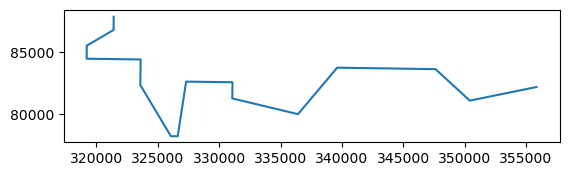

In [94]:
south_downs_np.plot()

In [57]:
south_downs_np.head(20)

,id,geometry,bicycle,boundary,foot,highway,horse,lanes,motorcar,name,surface,leisure,name:gd,natural,note,place,source,wikidata,wikipedia,access,leaf_cycle,leaf_type,protect_class,website,designation,operator,operator:type,operator:wikidata,tourism,archaeological_site,embankment,fortification_type,historic,historic:civilization,alt_name,communication:amateur_radio:pota,source:name,description,layer,salt,tidal,wetland,landcover,protection_title,url,start_date,FIXME,fixme,loc_name,old_name,landuse,contact:website,ref:GB:uprn,url:bexhillnature,wikimedia_commons,wikimedia_commons:pano,name:is,short_name,short_name:cs,contact:email,contact:facebook,ref:charity,wikimedia_commons:1,wikimedia_commons:2,addr:housename,addr:postcode,addr:street,fixme:designation,source:designation,note:name,civilization,historic:era,historic:period,megalith_type,opening_hours,wheelchair,conservation_organization,dog,managed,ownership,source:protection_title,name:cy,protect_id,area,protected_area,plant_community,Fixme,fee,ruins,barrier,fence_type,access_land,flood_prone,meadow,owner,species,man_made,official_name,email,phone,name:signed,grassland,military,name:es,name:fr,name:ja,name:pt,name:ru,type,access:conditional,amenity,Lowland,protection_title2,check_date:opening_hours,heritage,heritage:operator,intermittent,water,governance_type,addr:city,protection_aim,valid_from,ref,notified_feature,resource,historic:operator,operator:short,name:la,disused:man_made,disused:product,heritage:website,image,name:he,ref:whc,whc:criteria,whc:inscription_date,whc:name,whc:website,whc:wikipedia,location,name:non,material,conservation,residential,denomination,name:zh,garden:type,name:en,ele,not:operator:wikidata,source:geometry,boundary_1,waterway,source:description,storage,top_soil,plant,protection_object,alt_name:en,size,source_ref:ref,abandoned:landuse,listed_status,name:uk,basin,addr:suburb,boundary_type,note:landuse,period,check_date,seamark:restricted_area:restriction,seamark:type,geological,animal,animal_shelter,animal_shelter:release,animal_shelter:sanctuary,disused:landuse,protected,alt_website,park,seasonal,taxon,inscription
45,36206673,"POLYGON ((458373.263 1214187.486, 460355.312 1...",NaN,protected_area,NaN,NaN,NaN,NaN,NaN,Hermaness National Nature Reserve,NaN,nature_reserve,Tèarmann Nàdair Nàiseanta Hermaness,NaN,NaN,NaN,NaN,Q4579490,en:Hermaness,NaN,NaN,NaN,NaN,https://www.nature.scot/enjoying-outdoors/plac...,NaN,NatureScot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hermaness NNR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81,93774835,"POLYGON ((522831.511 285797.245, 523075.787 28...",NaN,protected_area,NaN,NaN,NaN,NaN,NaN,Woodwalton Fen National Nature Reserve,NaN,nature_reserve,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Natural England,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NNR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
324,275654536,"POLYGON ((530178.417 107790.073, 530385.24

/tmp/ipykernel_70819/2475786161.py:7: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


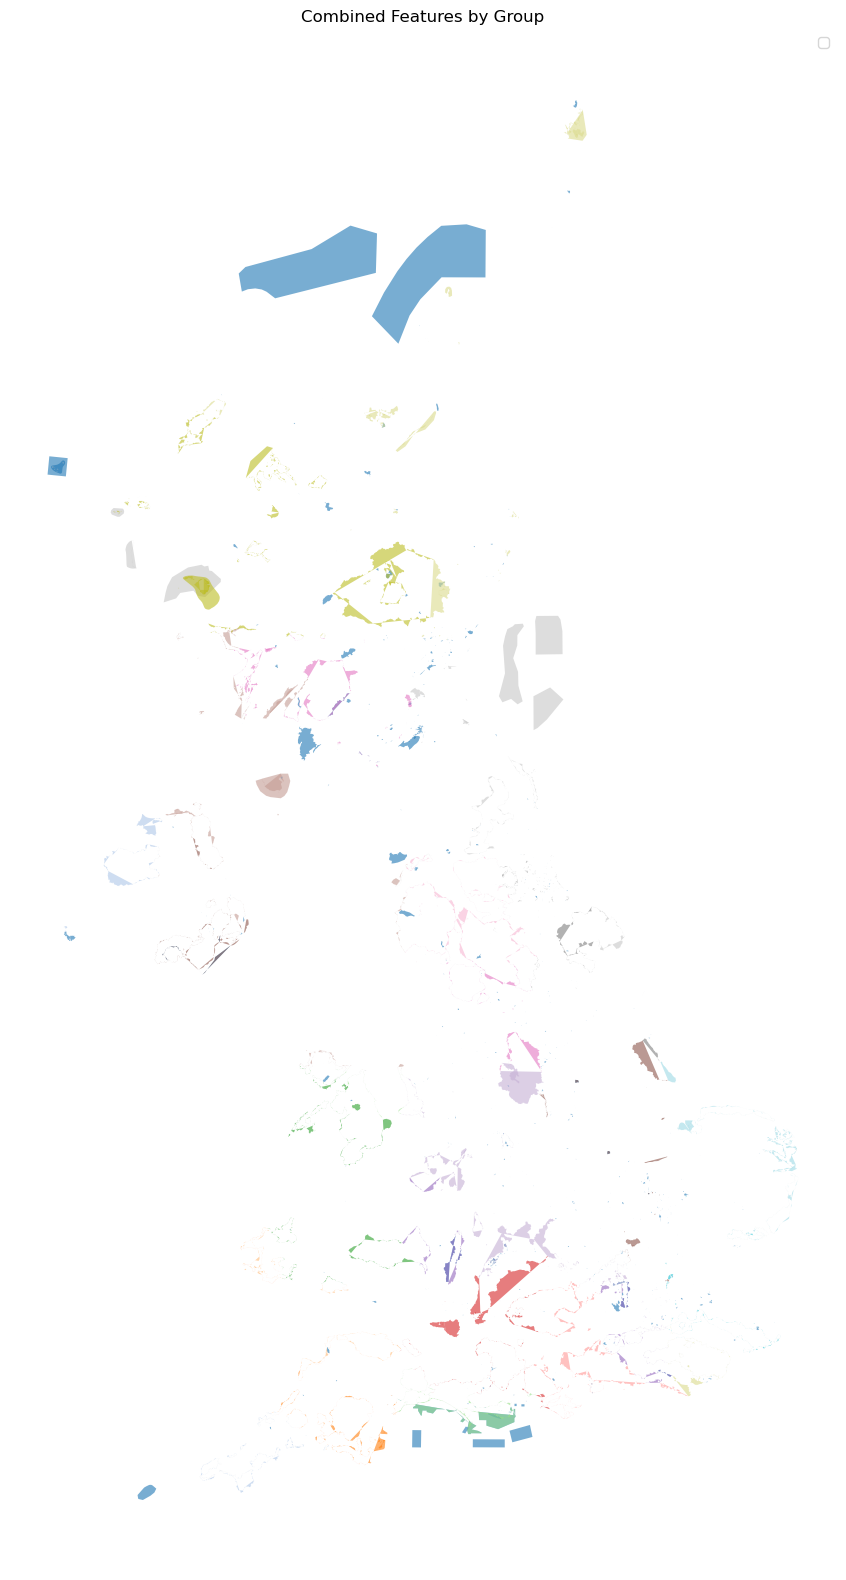

In [29]:
# fig, ax = plt.subplots(figsize=(20, 20))

# for name, gdf in features_1.items():
#     gdf.plot(ax=ax, label=name, cmap='tab20', alpha=0.6)

# plt.title("Combined Features by Group")
# plt.legend()
# plt.axis('off')
# plt.show()

In [5]:
#filtering the 1st set of features
features_1_filtered = {}

min_area_m2 = 1_000_000

for name, gdf in features_1.items():
    gdf = gdf.copy()
    gdf['area_m2'] = gdf.geometry.area

    print(f"Filtering {name}...")
    filtered_gdf = gdf[gdf['area_m2'] >= min_area_m2]
    print(f"Filtered parks (> {min_area_m2:,} m²): {len(filtered_gdf)}")

    features_1_filtered[f"{name}_filtered"] = filtered_gdf

NameError: name 'features_1' is not defined

In [24]:
#exporting the first set of features

# List to collect GeoDataFrames
features_list = []

# Loop through each feature in your filtered dictionary
for key, feature in features_1_filtered.items():
    print(key)
    features_list.append(feature)

# Concatenate all GeoDataFrames together into one GeoDataFrame
all_features = gpd.GeoDataFrame(pd.concat(features_list, ignore_index=True))

# Write the combined GeoDataFrame to a GeoJSON file
all_features.to_file("all_features.geojson", driver="GeoJSON")

gdf_parks_filtered
gdf_nature_reserves_filtered
gdf_gardens_filtered
gdf_protected_areas_filtered


In [ ]:
# Assuming gdf_protected_areas is your GeoDataFrame
fig, ax = plt.subplots(figsize=(10, 10))

# Plot with a colormap to assign a different color to each feature
gdf_protected_areas.plot(ax=ax, cmap='tab20', legend=True)

# Add title and other plot settings
plt.title("Protected Areas with Unique Colors")
plt.axis('off')
plt.show()

In [6]:
test_features = gpd.read_file("natural_assets_data_raw/all_features.geojson")

/opt/conda/lib/python3.11/site-packages/pyogrio/raw.py:196: RuntimeWarning: Several features with id = 87884444 have been found. Altering it to be unique. This warning will not be emitted anymore for this layer
  return ogr_read(


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


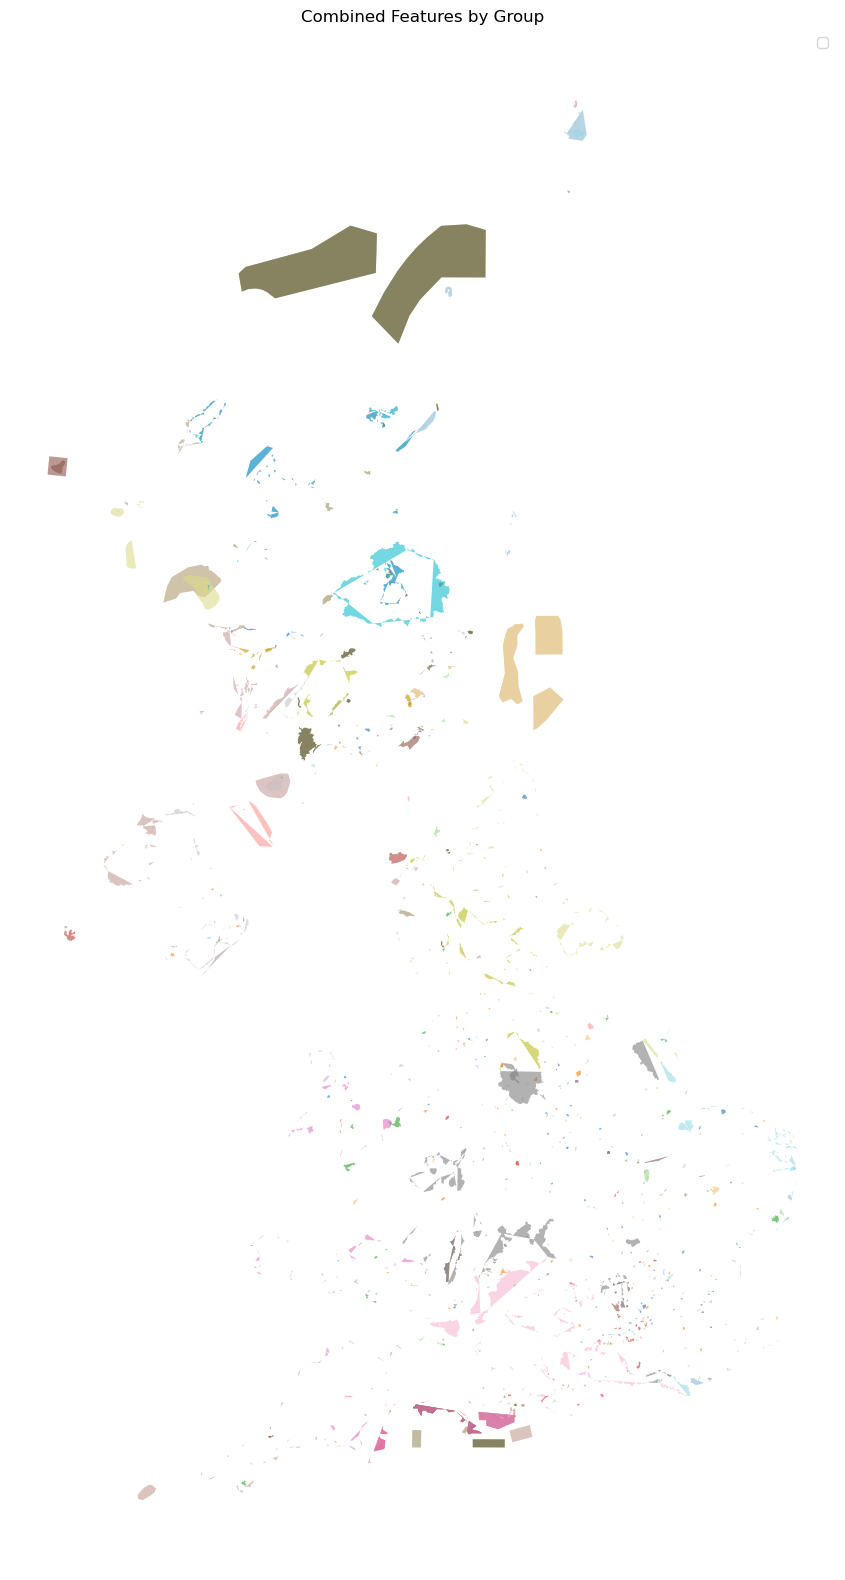

In [9]:
fig, ax = plt.subplots(figsize=(20, 20))

test_features.plot(ax=ax,cmap='tab20', alpha=0.6)

plt.title("Combined Features by Group")
plt.legend()
plt.axis('off')
plt.show()

In [3]:
natural_values = [
    "wood"
    # , "tree", "tree_row", "scrub", "heath", "grassland", "fell", "bare_rock",
    # "scree", "shingle", "sand", "mud", "beach", "dune", "cliff", "rock", "stone",
    # "water", "wetland", "glacier", "reef", "cave_entrance"
]

features_2 = {}

for val in natural_values:
    tag_2 = {"natural": val}
    gdf = fetch_osm_features("United Kingdom", tag_2, element_types=("way", "relation"))
    if gdf is not None and not gdf.empty:
        features_2[val] = gdf
        print(f"{val}: {len(gdf)} features")
    else:
        print(f"{val}: No features")

NameError: name 'requests' is not defined

/tmp/ipykernel_1557/1644174177.py:7: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


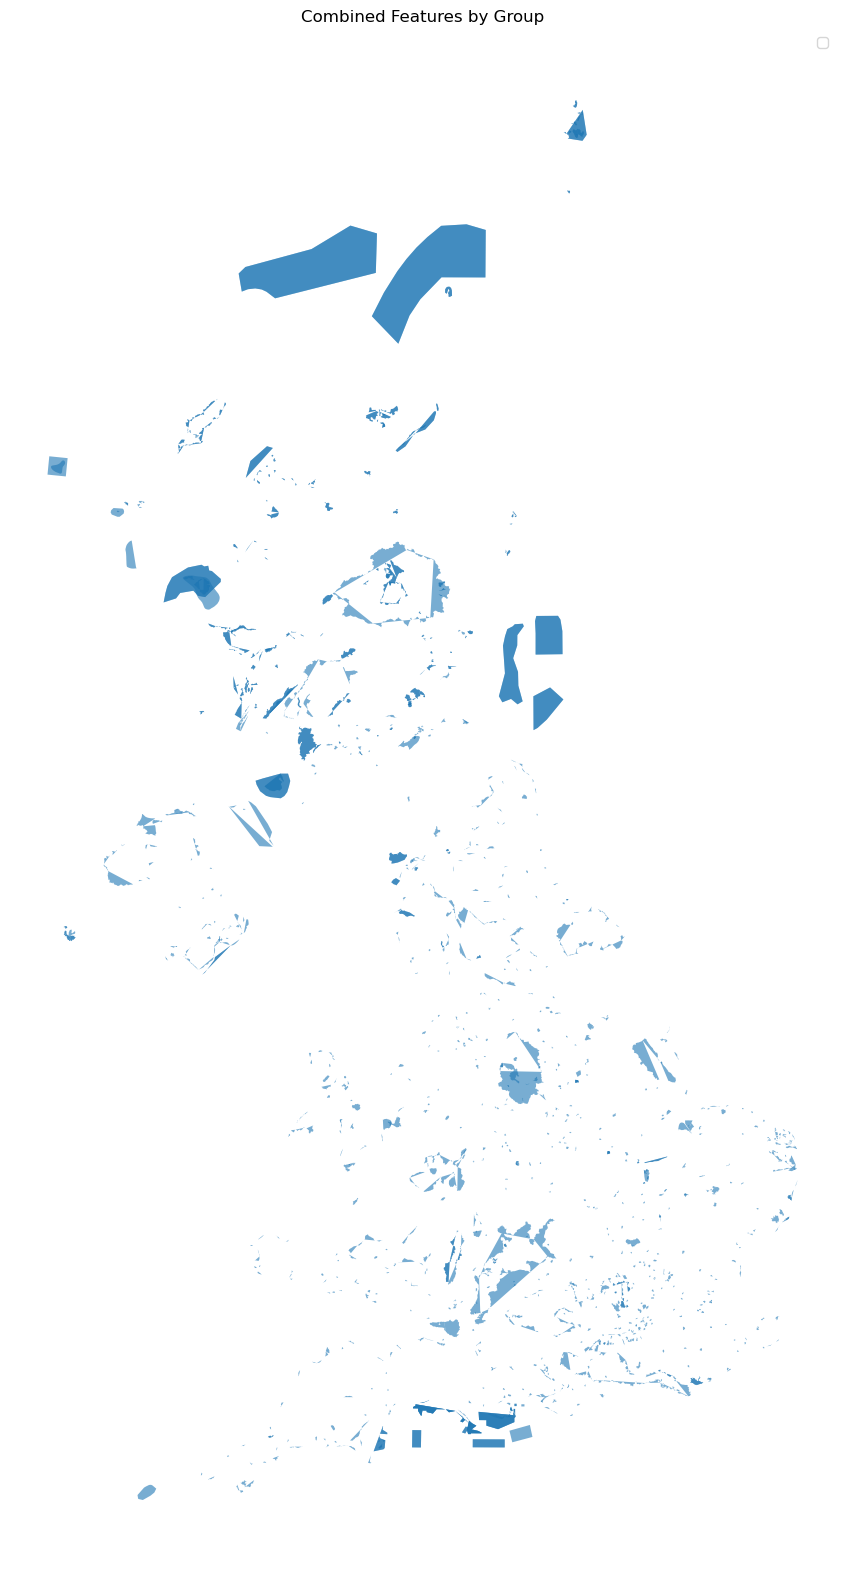

In [26]:
fig, ax = plt.subplots(figsize=(20, 20))

for name, gdf in features_1_filtered.items():
    gdf.plot(ax=ax, label=name, alpha=0.6)

plt.title("Combined Features by Group")
plt.legend()
plt.axis('off')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

# Plot with a colormap to assign a different color to each feature
features_1_filtered.gdf_protected_areas.items().plot(ax=ax, cmap='tab20', legend=True)

# Add title and other plot settings
plt.title("Protected Areas with Unique Colors")
plt.axis('off')
plt.show()

In [ ]:
tags = {
  "type": "railwayStation"
}

stations = fetch_osm_features("England", tags, element_types=("nodes"))

print(stations.head())
print(f"Total features: {len(stations)}")

# Save or plot
# gdf.to_file("filtered_features.geojson", driver="GeoJSON")
stations.plot()